In [1]:
import numpy as np
import pandas as pd

In [2]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

In [3]:
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

import neural_lib as nl

In [4]:
PATH = 'C:\\Users\\Ayub\\Downloads\\datasets\\heart_disease_uci.csv'
df = pd.read_csv(PATH)

In [5]:
df.drop(['id'], axis=1, inplace=True)

In [6]:
y = df['num'].apply(lambda x: x > 0)
X = df.drop(['num'], axis=1)

In [7]:
from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [8]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

In [9]:
cols = X.columns
for col in cols:
    if X[col].dtype == 'O':
        X[col] = X[col].astype("category")

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", enable_categorical=True, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('f1_score is ', f1_score(y_test, y_pred))

[[109  28]
 [ 20 119]]
f1_score is  0.8321678321678322


In [12]:
df.isnull().sum()

age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

def split_binarize(X, y, threshold=10):
    X.index = [str(id) for id in list(X.index)]
    y_bin = y.apply(lambda x: True if (x=='1' or x==1) else False)
    X = X.select_dtypes(include=['category'])
    X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3)

    def to_string(x):
        if type(x) not in ['string', 'float', 'int']:
            return str(x)
        return x

    cols = X.columns
    onehotencoder = OneHotEncoder()
    X_train_bin = X_train.copy()
    X_test_bin = X_test.copy()

    for col in cols:
        if X_train[col].isnull().sum() > 0:
            X_train[col] = X_train[col].cat.add_categories(['Unknown'])
            X_test[col] = X_test[col].cat.add_categories(['Unknown'])
            X_train[col] = X_train[col].fillna("Unknown")
            X_test[col] = X_test[col].fillna("Unknown")

    for col in cols:
        if len(X_train[col].value_counts()) > 10:
            continue
        X_train[col] = X_train[col].apply(to_string)
        X_test[col] = X_test[col].apply(to_string)
        res = onehotencoder.fit_transform(X_train[[col]])
        X_train_bin[onehotencoder.categories_[0]] = res.toarray()
        res = onehotencoder.transform(X_test[[col]])
        X_test_bin[onehotencoder.categories_[0]] = res.toarray()

        X_train_bin.drop([col], axis=1, inplace=True)
        X_test_bin.drop([col], axis=1, inplace=True)


    cols = X_train_bin.columns
    for col in cols:
        X_train_bin[col] = X_train_bin[col].apply(lambda x : False if (x==0 or x == '0') else True)
        X_test_bin[col] = X_test_bin[col].apply(lambda x : False if (x==0 or x == '0') else True)

    return X_train_bin, X_test_bin, y_train, y_test


In [14]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = split_binarize(X, y)

In [15]:
K_train = FormalContext.from_pandas(X_train_bin)
K_train

FormalContext (644 objects, 21 attributes, 3850 connections)
   |Female|Male|Cleveland|Hungary|Switzerland|...|downsloping|flat|upsloping|fixed defect|reversable defect|
870|      |   X|         |       |           |...|           |   X|         |            |                 |
669|      |   X|         |       |          X|...|           |   X|         |            |                 |
37 |      |   X|        X|       |           |...|           |   X|         |           X|                 |
586|      |   X|         |      X|           |...|           |   X|         |            |                 |
108|      |   X|        X|       |           |...|           |   X|         |            |                X|
871|      |   X|         |       |           |...|           |    |         |            |                 |
818|      |   X|         |       |           |...|           |    |        X|            |                 |
145|      |   X|        X|       |           |...|           |    |

In [16]:
L = ConceptLattice.from_context(K_train, is_monotone=True, algo='Sofia')
len(L)

96

In [17]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train_bin, y_preds)

In [18]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:14])

len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects


True

In [19]:
L.measures['f1_score']

array([0.        , 0.12598425, 0.31578947, 0.50682261, 0.3011583 ,
       0.54205607, 0.43065693, 0.48571429, 0.30088496, 0.35273369,
       0.32986111, 0.4219554 , 0.38991597, 0.58252427, 0.68064516,
       0.60128617, 0.625     , 0.36966825, 0.48673947, 0.48673947,
       0.39876352, 0.44239631, 0.54021244, 0.47289157, 0.3963964 ,
       0.48348348, 0.66567608, 0.54733728, 0.53313697, 0.57184751,
       0.41055718, 0.70087977, 0.36758321, 0.62553802, 0.72830725,
       0.53125   , 0.42372881, 0.56582633, 0.55354659, 0.51111111,
       0.61666667, 0.54923717, 0.52908587, 0.60941828, 0.56509695,
       0.80055402, 0.56984786, 0.5309973 , 0.63721553, 0.45247657,
       0.51069519, 0.55672823, 0.63885267, 0.6865285 , 0.57697283,
       0.66149871, 0.47948718, 0.45326504, 0.61203585, 0.59090909,
       0.53549191, 0.56966708, 0.61405672, 0.59926918, 0.57487923,
       0.59205776, 0.64981949, 0.74162679, 0.72228844, 0.66980024,
       0.78362573, 0.72196262, 0.67832168, 0.70465116, 0.73379

In [20]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train_bin)))

In [21]:
vis = LineVizNx(node_label_font_size=6, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [22]:
descr = {'Female', 'Male', 'Cleveland', 'flat'}

traced = cn.trace_description(descr, include_targets=False)

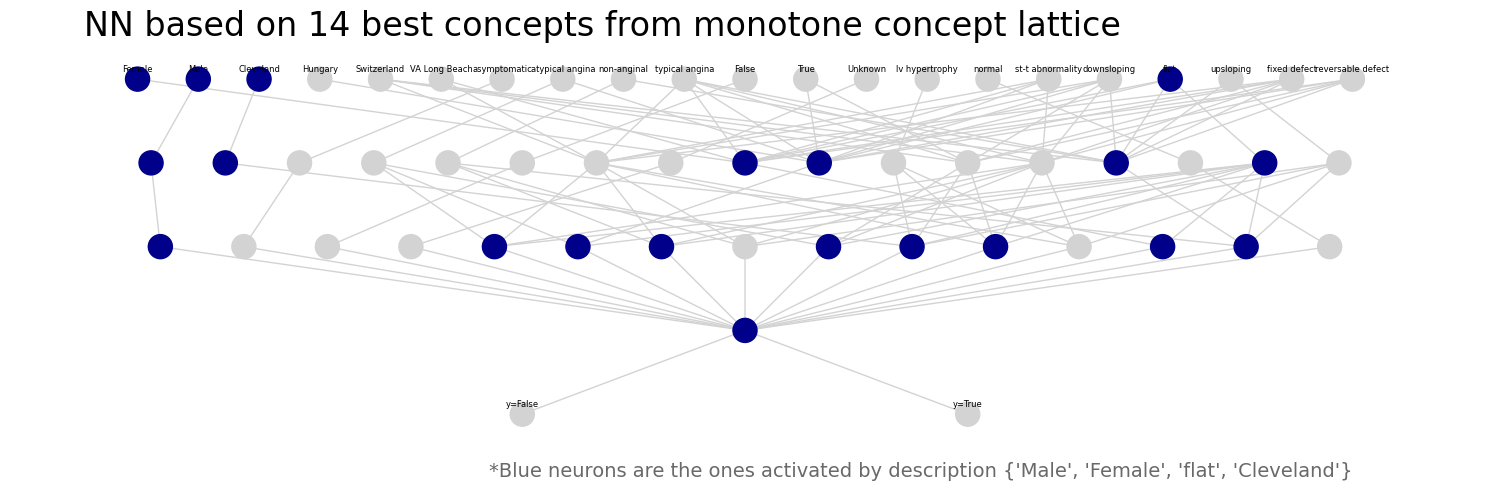

In [23]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 14 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [24]:
cn.fit(X_train_bin, y_train_bin)

In [25]:
print('Class prediction', cn.predict(X_test_bin).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test_bin).detach().numpy())
print('True class', y_test_bin.values)

Class prediction [1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1
 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 1
 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1
 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0
 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 1
 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 1
 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 0
 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1]
Class prediction with probabilities [[3.8226869e-02 9.6177310e-01]
 [3.8226869e-02 9.6177310e-01]
 [3.8226869e-02 9.6177310e-01]
 [7.1947879e-01 2.8052124e-01]
 [3.8226869e-02 9.6177310e-01]
 [3.8226869e-02 9.6177310e-01]
 [3.8226869e-02 9.6177310e-01]
 [9.9997449e-01 2.5553840e-05]
 [7.8537488e-01 2.1462509e-01]
 [3.8226869e-02 9.6177310e-01]
 [7.8537488e-01 2.1462509e-01]
 [1.8487431e-01 8.1512570e-01]
 [3.8226869e-0

In [26]:
f1_score(cn.predict(X_test_bin).numpy(), y_test_bin)

0.8024691358024691

In [27]:
##Compare with XGboost on the same set of attributes
xgb_model = xgb.XGBClassifier(objective="binary:logistic", enable_categorical=True, random_state=42)
xgb_model.fit(X_train_bin, y_train_bin)

y_pred = xgb_model.predict(X_test_bin)

print(confusion_matrix(y_test_bin, y_pred))
print('f1_score is ', f1_score(y_test_bin, y_pred))

[[ 89  28]
 [ 31 128]]
f1_score is  0.8126984126984127


In [28]:
edge_weights = cn.edge_weights_from_network()

C:\Users\Ayub\anaconda3\Lib\site-packages\sparselinear\sparselinear.py:301: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:607.)
  weight = torch.sparse.FloatTensor(self.indices, self.weights, (self.out_features, self.in_features))


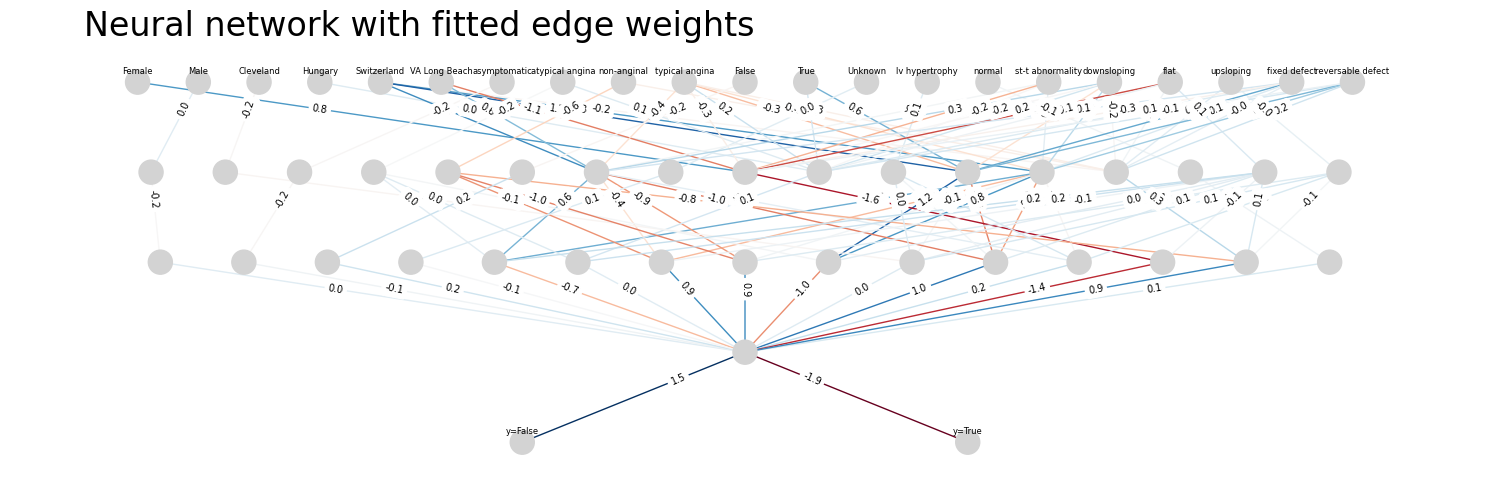

In [29]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7, font_size=7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

# 2. Wine quality

In [91]:
PATH = 'C:\\Users\\Ayub\\Downloads\\datasets\\winequalityN.csv'
df = pd.read_csv(PATH)

In [92]:
df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [93]:
X = df.drop(['quality'], axis=1)
y = df['quality']

In [94]:
def g(x):
    if 3<=x<=4:
        return 0
    if x==5:
        return 1
    if x ==6:
        return 2
    if x == 7:
        return 3
    if 8<=x<=9:
        return 4
    
y=y.apply(g)

In [95]:
#reduce the size of dataset
from sklearn.model_selection import train_test_split

X, X_tr, y, y_tr = train_test_split(X, y, test_size=11/13, stratify=y)

In [96]:
X.fillna(method='backfill', inplace=True)

In [97]:
X.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [99]:
cat_features=['type']

In [100]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=10,
#     verbose=5,
)

clf.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
)

Learning rate set to 0.5
0:	learn: 1.3114068	test: 1.3460590	best: 1.3460590 (0)	total: 6.06ms	remaining: 54.5ms
1:	learn: 1.1832350	test: 1.2556481	best: 1.2556481 (1)	total: 12.8ms	remaining: 51.2ms
2:	learn: 1.1141644	test: 1.2279216	best: 1.2279216 (2)	total: 18.4ms	remaining: 43ms
3:	learn: 1.0444860	test: 1.1989956	best: 1.1989956 (3)	total: 23.5ms	remaining: 35.3ms
4:	learn: 1.0080883	test: 1.1863578	best: 1.1863578 (4)	total: 28.9ms	remaining: 28.9ms
5:	learn: 0.9702503	test: 1.1835255	best: 1.1835255 (5)	total: 33.7ms	remaining: 22.5ms
6:	learn: 0.9378952	test: 1.1794894	best: 1.1794894 (6)	total: 38.3ms	remaining: 16.4ms
7:	learn: 0.9154157	test: 1.1793530	best: 1.1793530 (7)	total: 43.4ms	remaining: 10.8ms
8:	learn: 0.8929325	test: 1.1654891	best: 1.1654891 (8)	total: 48ms	remaining: 5.33ms
9:	learn: 0.8819790	test: 1.1709128	best: 1.1654891 (8)	total: 52.9ms	remaining: 0us

bestTest = 1.165489116
bestIteration = 8

Shrink model to first 9 iterations.


In [101]:
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)
f1_score(y_pred, y_test, average='macro')

0.2572203826342899

In [102]:
# onehot for numerical data
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer

In [103]:
#ad namings


def onehot_bin(df_train, df_test):
    def to_string(x):
        if type(x) not in ['string', 'float', 'int']:
            return str(x)
        return x
    
    X_train = df_train.copy()
    X_test = df_test.copy()
    X_train.index = [str(id) for id in list(X_train.index)]
    X_test.index = [str(id) for id in list(X_test.index)]

    categ_cols = X_train.select_dtypes(include=['category']).columns
    obj_cols = X_train.select_dtypes(include=['object']).columns
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
    onehotencoder = OneHotEncoder()
    
    for col in categ_cols:
        if X_train[col].isnull().sum() > 0:
            X_train[col] = X_train[col].cat.add_categories(['Unknown'])
            X_test[col] = X_test[col].cat.add_categories(['Unknown'])
            X_train[col] = X_train[col].fillna("Unknown")
            X_test[col] = X_[col].fillna("Unknown")

        X_train[col] = X_train[col].apply(to_string)
        X_test[col] = X_test[col].apply(to_string)
        res = onehotencoder.fit_transform(X_train[[col]])
        X_train[onehotencoder.categories_[0]] = res.toarray()
       
        res = onehotencoder.transform(X_test[[col]])
        X_test[onehotencoder.categories_[0]] = res.toarray()

        X_train.drop([col], axis=1, inplace=True)
        X_test.drop([col], axis=1, inplace=True)

    ### OBJECT
    for col in obj_cols:

        X_train[col] = X_train[col].apply(to_string)
        X_test[col] = X_test[col].apply(to_string)
        res = onehotencoder.fit_transform(X_train[[col]])
        X_train[onehotencoder.categories_[0]] = res.toarray()
        res = onehotencoder.transform(X_test[[col]])
        X_test[onehotencoder.categories_[0]] = res.toarray()

        X_train.drop([col], axis=1, inplace=True)
        X_test.drop([col], axis=1, inplace=True)


    ### NUMERICAL
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
    
    for col in num_cols:
        discret = KBinsDiscretizer(strategy = 'quantile', n_bins=4, encode = "onehot-dense")
        data_train = discret.fit_transform(X_train[[col]])
        data_test = discret.transform(X_test[[col]])
        edges = discret.bin_edges_[0]
        categ_names = [col+f'|{edges[i]}:{edges[i+1]}|' for i in range(len(edges)-1)]
        X_train[categ_names] = data_train
        X_test[categ_names] = data_test
        
        X_train.drop([col], axis=1, inplace=True)
        X_test.drop([col], axis=1, inplace=True)
                

    cols = X_train.columns
    for col in cols:
        X_train[col] = X_train[col].apply(lambda x : False if (x==0 or x == '0') else True)
        X_test[col] = X_test[col].apply(lambda x : False if (x==0 or x == '0') else True)

    return X_train, X_test

In [104]:
X_train_bin, X_test_bin = onehot_bin(X_train, X_test)

C:\Users\Ayub\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\Ayub\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [105]:
K_train = FormalContext.from_pandas(X_train_bin)
K_train

FormalContext (699 objects, 46 attributes, 9087 connections)
    |fixed acidity|4.4:6.5||fixed acidity|6.5:7.1||fixed acidity|7.1:7.8||fixed acidity|7.8:15.9||volatile acidity|0.08:0.24||...|alcohol|9.5:10.3||alcohol|10.3:11.3||alcohol|11.3:14.9||red|0.0:1.0||white|0.0:1.0||
3750|                      |                     X|                      |                       |                          X|...|                 |                  |                  |           X|             X|
314 |                     X|                      |                      |                       |                           |...|                X|                  |                  |           X|             X|
828 |                      |                      |                     X|                       |                          X|...|                 |                 X|                  |           X|             X|
333 |                      |                     X|                      |     

In [106]:
L = ConceptLattice.from_context(K_train, is_monotone=True, algo='Sofia')
len(L)

101

In [107]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds, average='macro')

In [108]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:7])

len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects


False

In [109]:
L.measures['f1_score']

array([0.01381215, 0.07672293, 0.07391316, 0.09463273, 0.0726818 ,
       0.04878858, 0.08806555, 0.08726731, 0.06290109, 0.09150314,
       0.07878428, 0.06491995, 0.07191352, 0.06472013, 0.07993364,
       0.1090218 , 0.0544448 , 0.1065223 , 0.07327177, 0.10468536,
       0.10053049, 0.07371974, 0.06623727, 0.08691058, 0.08691058,
       0.10293761, 0.0989893 , 0.10242537, 0.10946965, 0.09069002,
       0.07350892, 0.07792691, 0.09125416, 0.07104765, 0.05850726,
       0.10894489, 0.10363332, 0.08785393, 0.09739521, 0.06692123,
       0.07879066, 0.07307016, 0.07568741, 0.07948795, 0.07391621,
       0.10630727, 0.12310499, 0.11108384, 0.0774179 , 0.10727303,
       0.10731647, 0.10812714, 0.11910642, 0.10470783, 0.11835534,
       0.09817236, 0.09077   , 0.08560986, 0.09641209, 0.09819087,
       0.11293654, 0.09734224, 0.09047589, 0.09420409, 0.0909298 ,
       0.08304743, 0.10107493, 0.09743899, 0.10802406, 0.10046699,
       0.08570031, 0.12013691, 0.08320285, 0.09711621, 0.08587

In [110]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

In [111]:
vis = LineVizNx(node_label_font_size=6, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

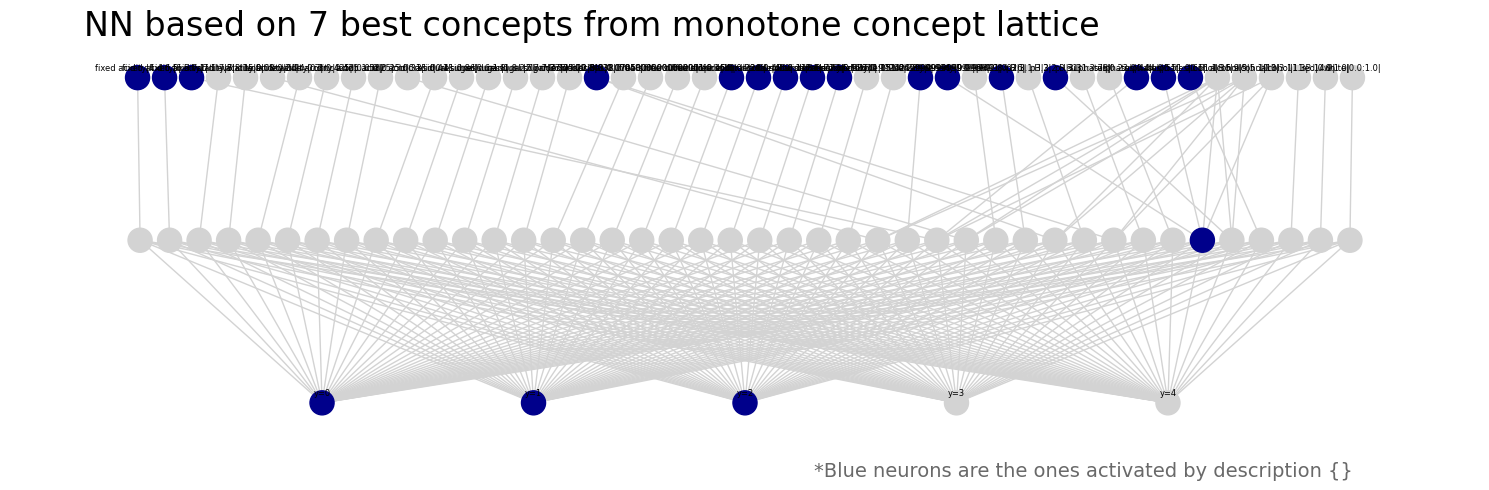

In [112]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 7 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [113]:
cn.fit(X_test_bin, y_test)

In [114]:
print('Class prediction', cn.predict(X_test_bin).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test_bin).detach().numpy())
print('True class', y_test.values)

Class prediction [2 1 2 2 1 1 1 1 2 1 2 2 1 2 2 1 2 2 2 1 2 2 1 2 2 2 2 1 1 1 2 1 2 2 2 2 2
 2 2 2 2 1 1 1 2 1 1 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 2 2 2 2 2 1 1 2 2 1 1 2 1 2 1 2 2 2 2 1 1 2 2 2 1 2 2 1 1 2 1 2
 2 2 2 1 2 2 2 2 2 2 2 1 2 2 1 2 1 2 2 2 1 1 2 2 1 1 1 2 2 2 1 2 2 2 2 2 2
 2 2 2 2 2 1 1 2 2 1 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2
 1 2 1 2 1 1 2 2 2 2 2 2 2 2 1 2 2 1 2 1 1 2 2 2 2 1 1 2 1 1 1 2 2 2 2 1 2
 1 2 1 1 2 2 1 2 2 2 2 1 1 1 2 2 2 1 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 1
 1 2 2 2 2 1 2 1 2 1 2 2 2 1 2 2 2 2 2 1 2 2 2 1 2 1 2 2 1 2 1 1 2 2 2 1 2
 2 1 2 2]
Class prediction with probabilities [[4.1573690e-05 2.2237796e-01 7.7744961e-01 5.6701505e-05 7.4143725e-05]
 [4.3560294e-06 9.9562520e-01 4.3576355e-03 6.7094961e-06 6.0392517e-06]
 [4.2135926e-09 1.8243124e-09 1.0000000e+00 3.3392902e-09 7.4871958e-09]
 ...
 [2.2548693e-06 9.9957567e-01 4.1440167e-04 4.2579809e-06 3.3409995e-06]
 [6.5557419e-05 2.0943078e-01 7.9033023e

In [115]:
f1_score(cn.predict(X_test_bin).numpy(), y_test, average='macro')

0.2656685160584512

In [123]:
##Compare with XGboost on the same set of attributes
xgb_model = xgb.XGBClassifier(objective="multi:softprob", enable_categorical=True, random_state=42)
xgb_model.fit(X_train_bin, y_train)

y_pred = xgb_model.predict(X_test_bin)

print(confusion_matrix(y_test, y_pred))
print('f1_score is ', f1_score(y_test, y_pred, average='macro'))

[[ 0  7  5  1  0]
 [ 2 46 45  5  2]
 [ 1 36 74 12  3]
 [ 0  9 23 17  0]
 [ 0  0  6  4  2]]
f1_score is  0.3184004733240727


In [124]:
edge_weights = cn.edge_weights_from_network()

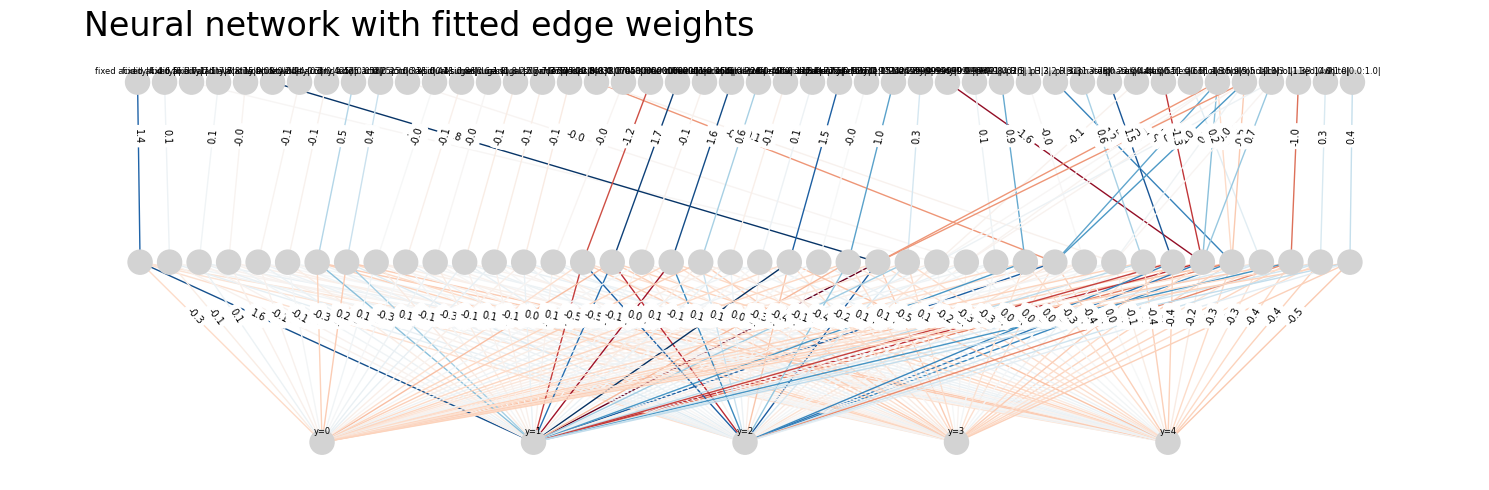

In [125]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7, font_size=7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

# 3. Malware detection 

In [269]:
PATH = 'C:\\Users\\Ayub\\Downloads\\datasets\\uci_malware_detection.csv'
df = pd.read_csv(PATH)

In [270]:
df = df.drop_duplicates ()

In [271]:
y = df['Label']
X = df.drop(['Label'],axis=1)

In [272]:
# binarize
y = y.apply(lambda x: 0 if x=='malicious' else 1)

In [273]:
X.index = [str(id) for id in list(X.index)]

In [274]:
cols = X.columns
for col in cols:
        X[col] = X[col].apply(lambda x : False if (x==0 or x == '0') else True)

In [275]:
for col in X.columns:
    if len(X[col].value_counts()) <= 1:
        X.drop([col], axis=1, inplace=True)

In [276]:
#Feature selection based on decision tree

In [277]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [278]:
features = {}
cols = X_train.columns
for i in range(len(cols)):
    features[f'f{i}'] = cols[i]

Feature ranking:
1. F_20 0.054104 
2. F_21 0.045238 
3. F_163 0.037477 
4. F_141 0.036688 
5. F_140 0.035224 
6. F_67 0.032165 
7. F_52 0.028117 
8. F_114 0.026292 
9. F_70 0.024914 
10. F_68 0.024199 
11. F_112 0.024087 
12. F_386 0.023431 
13. F_185 0.022705 
14. F_267 0.021483 
15. F_183 0.020326 
16. F_51 0.019397 
17. F_321 0.018783 
18. F_50 0.018660 
19. F_335 0.018161 
20. F_180 0.017842 
21. F_279 0.016200 
22. F_54 0.015436 
23. F_498 0.014863 
24. F_363 0.014342 
25. F_292 0.012879 
26. F_56 0.010606 
27. F_401 0.010446 
28. F_291 0.010426 
29. F_187 0.009841 
30. F_319 0.009685 
31. F_31 0.009474 
32. F_324 0.008243 
33. F_436 0.008089 
34. F_418 0.007593 
35. F_33 0.007533 
36. F_317 0.007510 
37. F_332 0.007463 
38. F_23 0.007447 
39. F_331 0.007322 
40. F_48 0.007213 
41. F_53 0.007184 
42. F_30 0.007060 
43. F_117 0.007029 
44. F_201 0.005979 
45. F_400 0.005768 
46. F_476 0.005707 
47. F_190 0.005531 
48. F_130 0.005476 
49. F_395 0.005257 
50. F_303 0.004990 
51. F_48

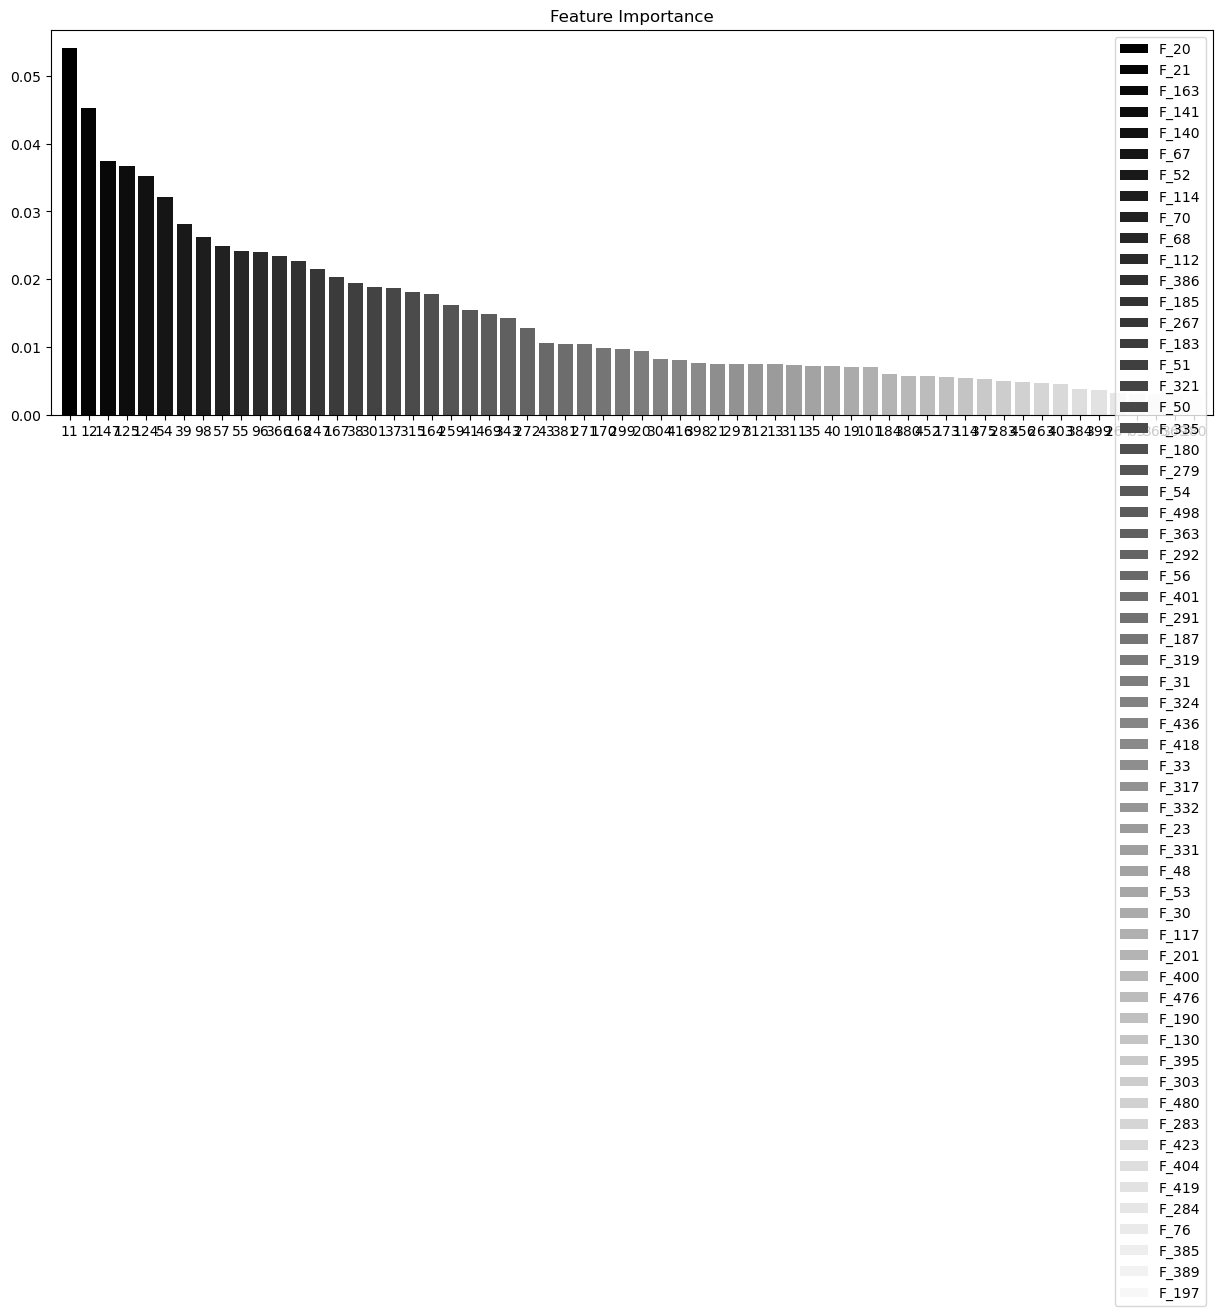

In [279]:
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier(n_estimators=1000, random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 60
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print(
        "%d. %s %f "
        % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
    )
plt.figure(figsize=(15, 5))
plt.title(u"Feature Importance")
bars = plt.bar(
    range(num_to_plot),
    importances[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices]);

In [280]:
best_60_feats = [features[f'f{i}'] for i in feature_indices]
best_60_feats;

In [281]:
X = X[best_60_feats]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [282]:
K_train = FormalContext.from_pandas(X_train)

In [283]:
L = ConceptLattice.from_context(K_train, is_monotone=True, algo='Sofia')


In [284]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)

In [285]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:8])

len({g_i for c in L[best_concepts] for g_i in c.extent_i})#==K_train.n_objects


52

In [286]:
L.measures['f1_score']

array([0.        , 0.11538462, 0.1509434 , 0.18518519, 0.33898305,
       0.39344262, 0.41935484, 0.46875   , 0.49230769, 0.49230769,
       0.51515152, 0.51515152, 0.53731343, 0.55882353, 0.6       ,
       0.6       , 0.63888889, 0.67567568, 0.18918919, 0.69333333,
       0.21333333, 0.71052632, 0.79012346, 0.38554217, 0.84705882,
       0.84705882, 0.42352941, 0.44186047, 0.44186047, 0.45977011,
       0.47727273, 0.8988764 , 0.49438202, 0.91111111, 0.91111111,
       0.52747253, 0.52747253, 0.96842105, 0.58947368, 0.97916667,
       0.60416667, 0.60416667, 0.97029703, 0.69902913, 0.72380952,
       0.75925926, 0.7706422 , 0.78181818, 0.81415929, 0.8245614 ,
       0.82352941, 0.44545455, 0.32      , 0.42982456, 0.34934498,
       0.32900433, 0.35744681, 0.39166667, 0.4       , 0.21561338,
       0.22222222, 0.25454545, 0.35379061, 0.1299639 , 0.27338129,
       0.13669065, 0.15      , 0.29787234, 0.29787234, 0.16312057,
       0.16312057, 0.16961131, 0.20422535, 0.20138889, 0.33910

In [287]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

In [288]:
vis = LineVizNx(node_label_font_size=6, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [289]:
descr = {'F_20', 'F_21', 'F_50', 'F_324'}

traced = cn.trace_description(descr, include_targets=False)

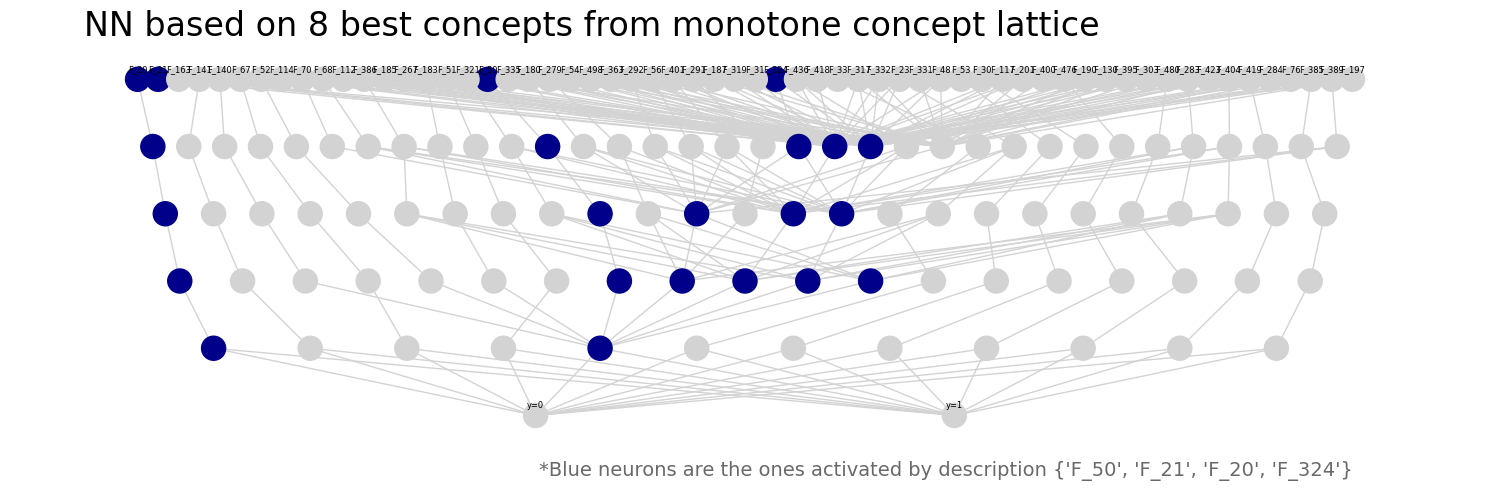

In [290]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 8 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [291]:
cn.fit(X_train, y_train)

In [292]:
print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
print('True class', y_test.values)

Class prediction [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
Class prediction with probabilities [[0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.00253688]
 [0.9974631  0.002

In [293]:
f1_score(cn.predict(X_test).numpy(), y_test)

0.0

In [294]:
##Compare with XGboost on the same set of attributes
xgb_model = xgb.XGBClassifier(objective="binary:logistic", enable_categorical=True, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('f1_score is ', f1_score(y_test, y_pred))

[[90  1]
 [ 0 21]]
f1_score is  0.9767441860465117


In [295]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=1000, random_state=0)

forest.fit(X_train, y_train)

y_preds = forest.predict(X_test)
print('f1_score is ', f1_score(y_test, y_preds))

f1_score is  0.9767441860465117


In [296]:
edge_weights = cn.edge_weights_from_network()

In [ ]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7, font_size=7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()